# An MCMC approach to the outburst decay model 
Based on [Powell et al. 2007](https://ui.adsabs.harvard.edu/abs/2007MNRAS.374..466P/abstract) and [Heinke et al. 2015](https://ui.adsabs.harvard.edu/abs/2015MNRAS.447.3034H/abstract).  We deploy this via [PyMC 3](https://docs.pymc.io/) ([Salvatier et al. 2016](https://doi.org/10.7717/peerj-cs.55)) package and use HMC ([Neal 2012](https://ui.adsabs.harvard.edu/?#abs/2012arXiv1206.1901N), [Betancourt 2017](https://ui.adsabs.harvard.edu/?#abs/2017arXiv170102434B)) with NUTS sampling ([Hoffman & Gelman 2011](https://ui.adsabs.harvard.edu/?#abs/2011arXiv1111.4246H)). It can be overkill in most cases, but given the model is piece-wise and data can be crummy, this bruteforce approach allows overcoming many of these issues.

## Setting up and loading necessary packages
**Packages used:**
- [Astropy](http://www.astropy.org/) ([Robitaille et al. 2013](https://ui.adsabs.harvard.edu/?#abs/2013A&A...558A..33A))
- [Corner](https://corner.readthedocs.io/en/latest/) ([Foreman-Mackey 2016](http://joss.theoj.org/papers/10.21105/joss.00024))
- [Matplotlib](https://matplotlib.org/) ([Hunter 2007](https://ieeexplore.ieee.org/document/4160265))
- [Numpy](http://www.numpy.org/) ([Oliphant 2006](https://archive.org/details/NumPyBook/page/n0))
- [PyMC 3](https://docs.pymc.io/) ([Salvatier et al. 2016](https://doi.org/10.7717/peerj-cs.55))
- [Theano](http://deeplearning.net/software/theano/) ([Al-Rfou et al. 2016](https://ui.adsabs.harvard.edu/abs/2016arXiv160502688T/abstract); used through PyMC3, no need to install separately)


In [2]:
import sys
import numpy as np
import pymc3 as pm
import corner
import astropy
from astropy.io import ascii

import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=False)
rc('font', family='serif')

rand_seed = np.random.randint(0, 2**32 - 1)
print('Random seed:',rand_seed)

# Package versions:
print('Running on:')
print(f'\tPython:\t\t{sys.version[:5]}')
print('\tAstropy\t\t{}'.format(astropy.__version__))
print('\tCorner\t\t{}'.format(corner.__version__))
print('\tMatplotlib\t{}'.format(plt.matplotlib.__version__))
print('\tNumpy\t\t{}'.format(np.__version__))
print('\tPyMC\t\t{}'.format(pm.__version__))

Random seed: 1277199705
Running on:
	Python:		3.8.1
	Astropy		4.2.1
	Corner		2.2.1
	Matplotlib	3.3.4
	Numpy		1.20.2
	PyMC		3.11.2


## Reading and preparing data

Typically the light curves contain data points from before or after the interval our model can reliably model. there are two statistical solutions to this: 1- either to define a parameter in the bayesian modeling framework that can probabilistically determine the optimized interval, or 2- do it manually based on visual inspection. 

While the former may be more appealing, it requires lots of hand-holding for modeling and care, and needs relatively good data (high number of data points), and it can be very slow. So, for many cases, the latter is far easier with mostly similar results. Here we use the latter, but I have developed a framework for the former method as well if needed.

In [3]:
# XTEJ1728-295
data = ascii.read('Lightcurves/xtej1728295_unabsorbedflux.txt', data_start=3, data_end=37)
outburst_start = 58580
outburst_end = 58800

data

Obs,ObsID,ObsMJD,Obsdate_err,Flux,Flux_uer,Flux_errmin,uplim
int64,int64,float64,float64,float64,float64,float64,str4
2,11303002,58588.083285,0.006022,2.13879914e-10,9.11884039e-12,9.44748659e-12,None
3,11303003,58590.143462,0.005557,1.97774366e-10,7.27142532e-12,7.50268641e-12,None
4,11303004,58592.463284,0.005876,1.58796161e-10,7.10033782e-12,7.40006019e-12,None
5,11303005,58594.521513,0.005993,1.63406753e-10,7.42961402e-12,7.73709837e-12,None
6,11303008,58602.034526,0.005441,1.5466071e-10,8.4291608e-12,9.00168679e-12,None
7,11303009,58604.681073,0.005158,1.06999069e-10,5.82343768e-12,6.11549087e-12,None
8,11303010,58606.745131,0.005978,1.19839503e-10,6.44786499e-12,6.84476869e-12,None
9,11303011,58608.795414,0.004991,9.80392545e-11,5.29691225e-12,5.52986021e-12,None
10,11303012,58610.895137,0.005196,9.83784555e-11,5.27117969e-12,5.50388121e-12,None


Filtering and preparing the data could be an iterative process and depends on the data in each case, here's an example were I grab the columns from the table above and cut out data outside my range of interest.

(In this particular case, there aren't any data points outside the range)

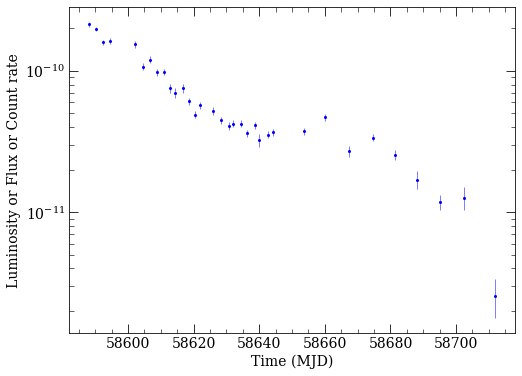

In [4]:
# outburst_start = 58583
# outburst_end = 58712

# Filtering to only include the data in the interval above
t_obs = data['ObsMJD'].data[(data['ObsMJD'] >= outburst_start) & (data['ObsMJD'] <= outburst_end)]
L_obs = data['Flux'].data[(data['ObsMJD'] >= outburst_start) & (data['ObsMJD'] <= outburst_end)]
L_obs_err = data['Flux_errmin'].data[(data['ObsMJD'] >= outburst_start) & (data['ObsMJD'] <= outburst_end)]

# We will keep the rest for plotting purposes
t_ignor = data['ObsMJD'].data[(data['ObsMJD'] < outburst_start) | (data['ObsMJD'] > outburst_end)]
L_ignor = data['Flux'].data[(data['ObsMJD'] < outburst_start) | (data['ObsMJD'] > outburst_end)]
L_ignor_err = data['Flux_errmin'].data[(data['ObsMJD'] < outburst_start) | (data['ObsMJD'] > outburst_end)]

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.errorbar(t_obs,L_obs,L_obs_err,fmt='.b',elinewidth=0.5,capsize=0,alpha=1.0,ms=4.0)
ax.errorbar(t_ignor,L_ignor,L_ignor_err,fmt='.k',elinewidth=0.5,capsize=0,alpha=0.2,ms=4.0)
ax.set_yscale('log')
ax.set_xlabel('Time (MJD)', fontsize=14)
ax.set_ylabel('Luminosity or Flux or Count rate', fontsize=14)
ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='major', length=9)
ax.tick_params(axis='both', which='minor', length=4.5)
ax.tick_params(axis='both', which='both',direction='in',right=True,top=True)

## Model setup and fitting preparation

The light curve decay model (based on [Powell et al. 2007](https://ui.adsabs.harvard.edu/abs/2007MNRAS.374..466P/abstract) and [Heinke et al. 2015](https://ui.adsabs.harvard.edu/abs/2015MNRAS.447.3034H/abstract)):

$$ L(t) = \left\{
        \begin{array}{ll}
            (L_t - L_e) \exp\left( - \frac{t-t_t}{\tau_e} \right)+L_e & \quad t \leq t_t \\
            L_t \left( 1-\frac{t-t_t}{\tau_l} \right) & \quad t > t_t
        \end{array}
    \right. $$

Where:
- $L_t$: Luminosity at the brink
- $L_e$: Exponential asymptotic luminosity ($0.4 L_t \leq L_e \leq L_t $)
- $t_t$: Time of the brink
- $\tau_e$: Exponential decay timescale
- $\tau_l$: Linear decay timescale

**NOTE: Through out this notebook, I use the word "luminosity" a bit loosely, $L_t$,$L_e$,$L(t)$ will be the same type of quantity and in the same unit as your input data (e.g., Flux, count rate, etc).**

Given the piece-wise nature of the model, setting it up for MCMC is delicate, so we have two versions it coded up, a "simple" model which is algebraic and straight-forward, and a second one labeled "theano", which is optimized for PyMC with Theano tensors. The difference is subtle and minor: it is only that the variables are expected to be  scalar quantities or `numpy` arrays for the "simple" model, while they are expected to be Theano tensors for a proper MCMC. Thus, the simple model is easy to use for plotting and checking, while the theano version is prepared for our MCMC analysis.

In [5]:
#Model:
def decay_model_simple(t,Lt,Le,tt,tau_e,tau_l):
    """
    Simple model to fit outburst decay of XRBs. 
    Consists of an initial exponential decay followed by a linear decay.
    
    This is a simple version.
    
    Parameters:
    -----------
    t: time (an array, values in MJD)
    
    Lt: luminosity at the brink
    
    Le: exponential asymptotic luminosity
    
    tt: time of the brink
    
    tau_e: exp decay timescale
    
    tau_l: linear decay timescale
    
    Output:
    -----------
    L: luminosity at time t
    
    """    

    Lexp = (Lt-Le)*np.exp(-(t[t <= tt]-tt)/tau_e)+Le    
    Llin = Lt*(1 - (t[t > tt]-tt)/tau_l)
    L = np.concatenate((Lexp,Llin))
    return L


def decay_model_theano(t,Lt,Le,tt,tau_e,tau_l):
    """
    Simple model to fit outburst decay of XRBs. 
    Consists of an initial exponential decay followed by a linear decay.
    
    This is a Theano-compatible version.
    
    Parameters:
    -----------
    t: time (an array, values in MJD)
    
    Lt: luminosity at the brink
    
    Le: exponential asymptotic luminosity
    
    tt: time of the brink
    
    tau_e: exp decay timescale
    
    tau_l: linear decay timescale
    
    Output:
    -----------
    L: luminosity at time t
    
    """    
    L = pm.math.switch(t <= tt, (Lt-Le)*np.exp(-(t-tt)/tau_e)+Le, Lt*(1 - (t-tt)/tau_l))
    return L


### Constraining the parameter space to search

We need to find initial estimates for the parameters in the model to start fitting (e.g., if we are off by a really large value in parameter, no matter how good the fitting algorithm, finding the best fit will be a challenge). So we iteratively test values until the model looks to roughly follow the data:

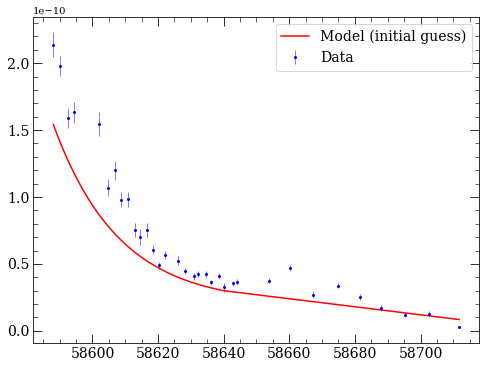

In [13]:
#initial guess values:
test_Lt = 3e-11
test_Le = 2e-11
test_tt = 58640
test_tau_e = 20
test_tau_l = 100

plot_t = np.linspace(t_obs.min(),t_obs.max(),num=2000)
plot_l = decay_model_simple(plot_t,test_Lt,test_Le,test_tt,test_tau_e,test_tau_l)
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.errorbar(t_obs,L_obs,L_obs_err,fmt='.b',elinewidth=0.5,capsize=0,alpha=1.0,ms=4.0, label='Data')
ax.plot(plot_t,plot_l,'-r', label='Model (initial guess)')
# ax.set_yscale('log')
ax.legend(fontsize=14)
ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='major', length=9)
ax.tick_params(axis='both', which='minor', length=4.5)
ax.tick_params(axis='both', which='both',direction='in',right=True,top=True)

It is close enough!

## Setting up the priors and the bayesian inference

Now, onto the actual fitting: we need to set up priors for our parameters and connect the model and data via likelihood. Our data consists of luminosity/flux/countrate measurements $y=[y_1,y_2,\cdots,y_N]$ and measurement uncertainties of $\sigma=[\sigma_1,\sigma_2,\cdots,\sigma_N]$ for times $t=[t_1,t_2,\cdots,t_N]$ and as before, our model was:

$$ L(t) = \left\{
        \begin{array}{ll}
            (L_t - L_e) \exp\left( - \frac{t-t_t}{\tau_e} \right)+L_e & \quad t \leq t_t \\
            L_t \left( 1-\frac{t-t_t}{\tau_l} \right) & \quad t > t_t
        \end{array}
    \right. $$

Where:
- $L_t$: Luminosity at the brink
- $L_e$: Exponential asymptotic luminosity ($0.4 L_t \leq L_e \leq L_t $)
- $t_t$: Time of the brink
- $\tau_e$: Exponential decay timescale
- $\tau_l$: Linear decay timescale

So, we define our statistical model as:

$$ \begin{array}{ll}
p(L_t,L_e,t_t,\tau_e,\tau_l|y) &\propto p(L_t,L_e,t_t,\tau_e,\tau_l)~p(y|L_t,L_e,t_t,\tau_e,\tau_l)\\
p(L_t,L_e,t_t,\tau_e,\tau_l|y) &\propto p(L_t,L_e,t_t,\tau_e,\tau_l)~\mathcal{L}(y,L(t))
\end{array}
$$

Where:
$$
\mathcal{L}(y,L(t)) = \prod_{i=1}^N \frac{1}{\sigma_i \sqrt{2\pi}} \exp\left[\frac{-(y_i - L(t))^2}{2\sigma_i^2} \right]
$$

despite its intimidating appearance is a simple Gaussian likelihood, and we assume the following priors:
- $\log_{10}(L_t) \sim \mathcal{U}(\log_{10}y_\min,\log_{10}y_\max)$
- $\log_{10}(L_e) \sim \mathcal{U}(\log_{10}(0.4 L_t),\log_{10}(L_t))$
- $t_t \sim \mathcal{U}(t_\min, t_\max)$
- $\tau_e \sim \mathcal{U}(?)$
- $\tau_l \sim \mathcal{U}(?)$

Where $\mathcal{U}(a,b)$ means a uniform prior probability distribution between $a$ and $b$. You notice that we defined the priors on the logarithm of $Lt$ and $Le$ instead of them. This is to consider [scale invariance](https://en.wikipedia.org/wiki/Scale_invariance) for these parameters. Simply put, this is because we want the prior probability of getting a value between $10^{-12}$ and $10^{-11}$ to be the same as $10^{-11}$ and $10^{-10}$. The priors for $\tau_e$ and $\tau_l$ depend on the case and need some consideration for every source separately.


## Fitting the data

While the notation and background for the concepts mentioned above may complex, implementing them for our fitting is actually rather simple:

In [14]:
with pm.Model() as model:
    #Lt = pm.Uniform('Lt',1e-12,3e-10)
    #Le = pm.Uniform('Le',0.4*Lt,Lt)
    logLt = pm.Uniform('logLt', -12, -10)
    logLe = pm.Uniform('logLe', np.log10(0.4)+logLt, logLt)
    tt = pm.Uniform('tt', 58580, 58710)
    tau_e = pm.Uniform(r'tau\_e', 1, 200)
    tau_l = pm.Uniform(r'tau\_l', 1, 200)
#     logLt = pm.Uniform('logLt', 0.01, 2)
#     logLe = pm.Uniform('logLe', np.log10(0.4)+logLt, logLt)
#     tt = pm.Uniform('tt', outburst_start+2, outburst_end-2)
#     tau_e = pm.Uniform(r'tau\_e', 1, 100)
#     tau_l = pm.Uniform(r'tau\_l', 1, 100)
    Lum = pm.Normal('Luminosity',
                    mu=decay_model_theano(t_obs, 10**logLt, 10**logLe, tt,tau_e, tau_l),
                    sd=L_obs_err, observed=L_obs)
    trace1 = pm.sample(draws=20000, chains=6, cores=12, tune=10000, random_seed=rand_seed)

pm.summary(trace1)

<ipython-input-14-f7bbf9afdf92>:17: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace1 = pm.sample(draws=20000, chains=6, cores=12, tune=10000, random_seed=rand_seed)
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 12 jobs)
INFO:pymc3:Multiprocess sampling (6 chains in 12 jobs)
NUTS: [tau\_l, tau\_e, tt, logLe, logLt]
INFO:pymc3:NUTS: [tau\_l, tau\_e, tt, logLe, logLt]


Sampling 6 chains for 10_000 tune and 20_000 draw iterations (60_000 + 120_000 draws total) took 87 seconds.
INFO:pymc3:Sampling 6 chains for 10_000 tune and 20_000 draw iterations (60_000 + 120_000 draws total) took 87 seconds.
There were 972 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 972 divergences after tuning. Increase `target_accept` or reparameterize.
There were 568 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 568 divergences after tuning. Increase `target_accept` or reparameterize.
There were 656 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 656 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1271 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 1271 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
logLt,-10.340,0.012,-10.363,-10.316,0.000,0.000,6183.0,3128.0,1.0
logLe,-10.697,0.033,-10.751,-10.632,0.001,0.000,3091.0,1497.0,1.0
tt,58629.282,1.391,58626.734,58631.964,0.021,0.015,4268.0,1588.0,1.0
tau\_e,20.216,0.685,18.921,21.479,0.011,0.008,3846.0,2106.0,1.0
tau\_l,92.049,1.850,88.590,95.517,0.020,0.014,8528.0,7406.0,1.0


Ok, let's go through the outputs above:


```
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 12 jobs)
NUTS: [tau\_l, tau\_e, tt, logLe, logLt]
Sampling 6 chains, 2,607 divergences: 100%|██████████| 180000/180000 [01:12<00:00, 2487.84draws/s]
```
This bit is just telling us that it is setting it up and running it, and the last line is a simple progress bar.

---
```
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
There were 221 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1175 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5502145415237404, but should be close to 0.8. Try to increase the number of tuning steps.
There were 492 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7201504152732185, but should be close to 0.8. Try to increase the number of tuning steps.
There were 367 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7084498025442265, but should be close to 0.8. Try to increase the number of tuning steps.
There were 279 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
```
This bit is telling us that our MCMC has generated some values that are not as "convergent" as expected. These are mostly minor and fine for now and we can ignore them for the moment (later, when we are benchmark testing the results, we can address them by increasing the values of `draw` and `tune` in our sampling.

## Visualizing the results

We are going to make a "trace" plot which will demonstrate how our MCMC sampling went, and a "corner" plot, which demonstrates how the posterior samples (best-fit value and uncertainties) look for each parameter.

<ipython-input-15-ec2adfefac45>:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace1)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


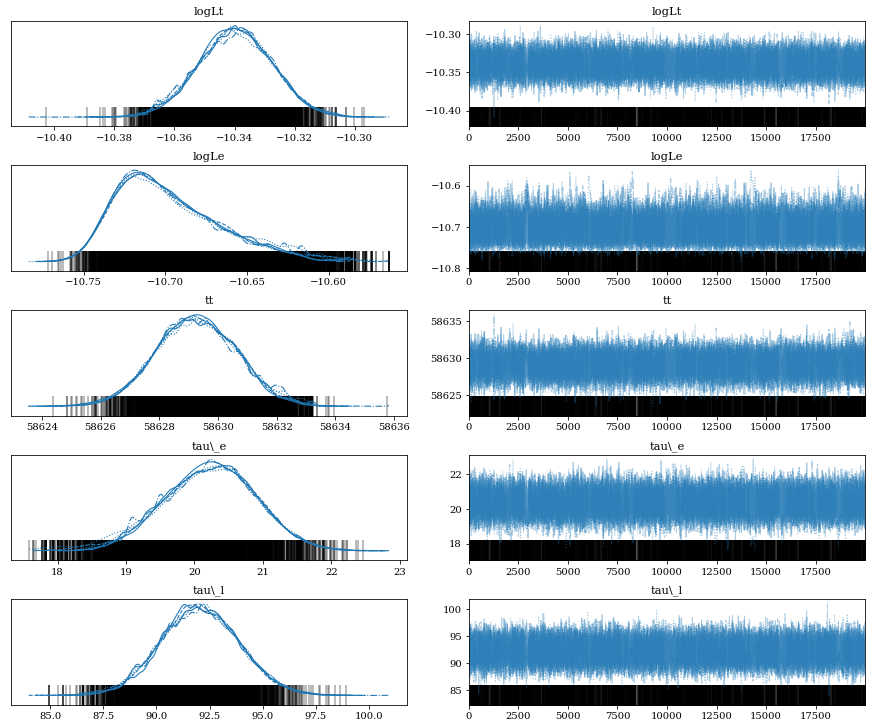

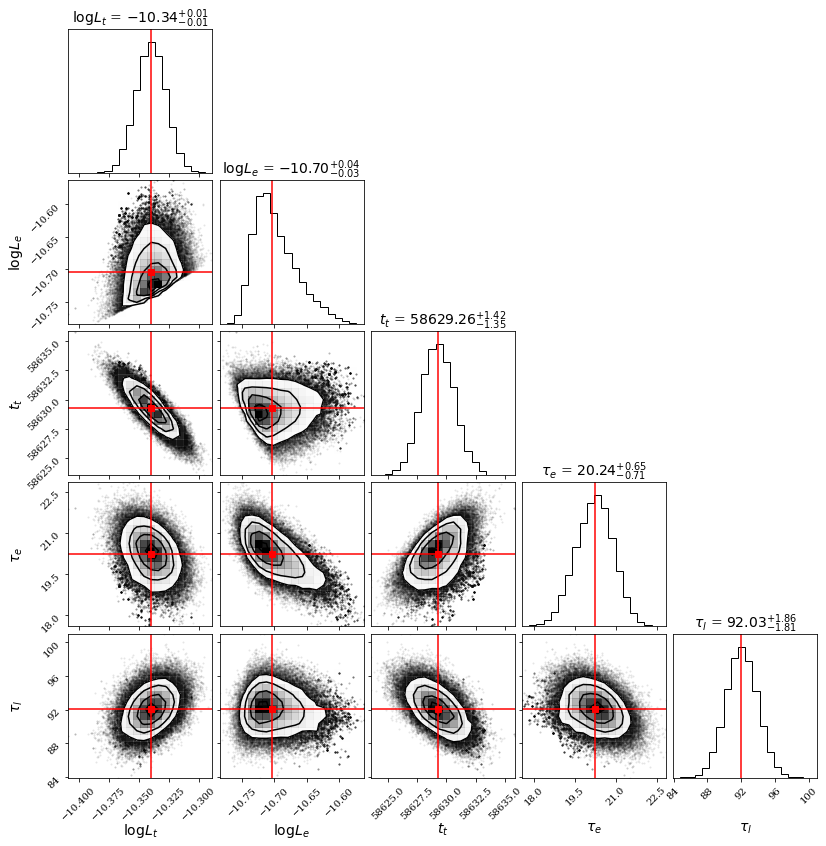

In [15]:
pm.traceplot(trace1)
#pm.plot_posterior(trace1,point_estimate='mode')


# Corner plot with distribution modes:
ndim = 5
medians = [np.median(trace1['logLt']),
           np.median(trace1['logLe']),
           np.median(trace1['tt']),
           np.median(trace1['tau\_e']),
           np.median(trace1['tau\_l'])]

corner_data = np.array(list(zip(*np.array([trace1.get_values('logLt'),
                                  trace1.get_values('logLe'),
                                  trace1.get_values('tt'),
                                  trace1.get_values('tau\_e'),
                                  trace1.get_values('tau\_l')]))))

cornplot = corner.corner(corner_data, show_titles=True, use_math_text=False,
                         labels=[r'$\logL_t$',r'$\logL_e$',r'$t_t$',r'$\tau_e$',r'$\tau_l$'],
                         title_kwargs={"fontsize": 14},label_kwargs={"fontsize": 14})

axes = np.array(cornplot.axes).reshape((ndim, ndim))
for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(medians[i], color="r")

for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(medians[xi], color="r")
        ax.axhline(medians[yi], color="r")
        ax.plot(medians[xi], medians[yi], "sr")


### And the final plot

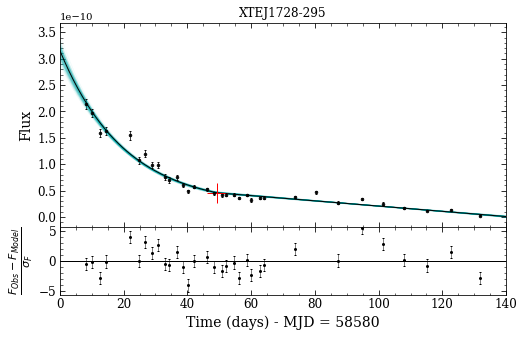

In [29]:
plot_start_date = outburst_start   # mjd
plot_length = outburst_end - outburst_start - 80 # days

fig = plt.figure(figsize=(8,5))

medians = [10**np.median(trace1['logLt']),
           10**np.median(trace1['logLe']),
           np.median(trace1['tt']),
           np.median(trace1['tau\_e']),
           np.median(trace1['tau\_l'])]


ax1 = plt.subplot2grid((4,1), (0,0), rowspan = 3,fig=fig)
plot_t = np.linspace(plot_start_date,plot_start_date+plot_length,num=200)
plot_L = decay_model_simple(plot_t, medians[0], medians[1], medians[2], medians[3], medians[4])


for i in np.random.randint(0,len(trace1),size=200):
    plot_L_samp = decay_model_simple(plot_t, 10**trace1['logLt'][i], 10**trace1['logLe'][i], 
                              trace1['tt'][i], trace1['tau\_e'][i], trace1['tau\_l'][i])
    ax1.plot(plot_t-plot_start_date,plot_L_samp,'c',lw=0.5,alpha=0.05)
#     plt.plot(trace1['tt'][i]-plot_start_date, decay_model_simple(trace1['tt'][i], 
#                                                trace1['logLt'][i], 
#                                                trace1['logLe'][i], 
#                                                trace1['tt'][i], 
#                                                trace1['tau\_e'][i], 
#                                                trace1['tau\_l'][i]),'+r',alpha=0.1)

ax1.plot(plot_t-plot_start_date,plot_L,'k',lw=1)

plt.plot(medians[2]-plot_start_date,decay_model_simple(medians[2],medians[0], medians[1], medians[2], medians[3], medians[4]),'+r', ms=20)

ax1.errorbar(t_obs-plot_start_date,L_obs,L_obs_err,fmt='.k',elinewidth=0.8,capsize=.8,ms=5.0,alpha=0.9)

ax1.errorbar(t_ignor-plot_start_date,L_ignor,L_ignor_err,fmt='.k',elinewidth=0.8,capsize=0.8,ms=5.0,alpha=0.1)

ax1.set_xlim(0,plot_length)
# ax1.set_ylim(-20,200)
# ax1.set_yscale('log')
ax1.set_ylabel(r'Flux',fontsize=14)
ax1.set_xticklabels([])

ax1.minorticks_on()
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.tick_params(axis='both', which='major', length=5)
ax1.tick_params(axis='both', which='minor', length=2.5)
ax1.tick_params(axis='both', which='both',direction='in',right=True,top=True)

# Title
ax1.set_title('XTEJ1728-295')

ax2 = plt.subplot2grid((4,1), (3,0), fig=fig)
sig = np.ones(len(t_obs))
resid = L_obs - decay_model_simple(t_obs,medians[0], medians[1], medians[2], medians[3], medians[4])

ax2.errorbar(t_obs-plot_start_date,resid/(L_obs_err),sig,fmt='.k',elinewidth=0.5,capsize=0.8,ms=4.0)

ax2.hlines(0,-2,200,linewidth=1,color='k')
ax2.set_xlabel(f'Time (days) - MJD = {plot_start_date}', fontsize=14)
ax2.set_ylabel(r'$\frac{F_{Obs}-F_{Model}}{\sigma_F}$', fontsize=16)
ax2.set_xlim(0,plot_length)
ax2.set_ylim(-5.6,5.6)
ax2.minorticks_on()
ax2.ticklabel_format(useOffset=False)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='major', length=5)
ax2.tick_params(axis='both', which='minor', length=2.5)
ax2.tick_params(axis='both', which='both',direction='in',right=True,top=True)

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.0)

fig.savefig('Finalplots/XTEJ1728-295_pr.png', dpi=200)